<a href="https://colab.research.google.com/github/Camillabgarcia/Apache_Spark_com_Python/blob/main/Spark_sistema_de_recomendacao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

01. Problema e Ferramenta

1.1 Configurando o PySpark

In [1]:
!pip install pyspark==3.3.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.3/281.3 MB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 kB 16.1 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.0-py2.py3-none-any.whl size=281764003 sha256=4e3289d4af5d5b6ef1b15bd656a0f8b1dbd5aa65e2ab11c0cbe4e82308d09c94
  Stored in directory: /root/.cache/pip/wheels/81/9c/6c/d5200fcf351ffa39cbe09911e99703283624cd037df58070d9
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.7
    Uninstalling py4j-0.10.9.7:
      Successfully uninstalled py4j-0.10.9.7


Importando a Classe SparkSession que é por onde vamos interagir com o Spark:

In [2]:
from pyspark.sql import SparkSession

Criando a sessão Spark, aqui podemos verificar a versão que estamos utilizando e o nome da nossa App Spark:

In [3]:
sessao_spark = SparkSession.builder\
                           .appName("Recomendador PySpark")\
                           .getOrCreate()
sessao_spark

02. Leitura e Análise de Dados

2.1 Leitura de dados pela URL do GitHub diretamente no Spark:

In [4]:
from pyspark import SparkFiles

In [5]:
url_dados = 'https://github.com/IgorNascAlves/dados/blob/main/dados_musicas.csv?raw=true'
sessao_spark.sparkContext.addFile(url_dados)
path_dados_file = 'file://' + SparkFiles.get('dados_musicas.csv')

In [6]:
dados = sessao_spark.read.csv(path_dados_file, header=True, sep=';', inferSchema=True)

Visualizando o dataframe:

In [7]:
dados.show()

+------------------+----+------------+--------------+------------------+-----------+------------------+--------+--------------------+--------------------+---+--------+-------------------+----+--------------------+----------+-----------+------------------+--------------------+
|           valence|year|acousticness|       artists|      danceability|duration_ms|            energy|explicit|                  id|    instrumentalness|key|liveness|           loudness|mode|                name|popularity|speechiness|             tempo|        artists_song|
+------------------+----+------------+--------------+------------------+-----------+------------------+--------+--------------------+--------------------+---+--------+-------------------+----+--------------------+----------+-----------+------------------+--------------------+
|             0.285|2000|     0.00239|      Coldplay|             0.429|     266773|0.6609999999999999|       0|3AJwUDP919kvQ9Qco...|             1.21E-4| 11|   0.234|  

Verificando os tipos das colunas:

In [8]:
dados.printSchema()

root
 |-- valence: double (nullable = true)
 |-- year: integer (nullable = true)
 |-- acousticness: double (nullable = true)
 |-- artists: string (nullable = true)
 |-- danceability: double (nullable = true)
 |-- duration_ms: integer (nullable = true)
 |-- energy: double (nullable = true)
 |-- explicit: integer (nullable = true)
 |-- id: string (nullable = true)
 |-- instrumentalness: double (nullable = true)
 |-- key: integer (nullable = true)
 |-- liveness: double (nullable = true)
 |-- loudness: double (nullable = true)
 |-- mode: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- popularity: integer (nullable = true)
 |-- speechiness: double (nullable = true)
 |-- tempo: double (nullable = true)
 |-- artists_song: string (nullable = true)



Verificando a quantidade de linhas:

In [9]:
dados.count()

20311

Verificando a quantidade de colunas:

In [10]:
len(dados.columns)

19

Verificando se existem dados nulos:

In [11]:
import pyspark.sql.functions as f

In [12]:
dados.select([f.count(f.when(f.isnull(c), 1)).alias(c) for c in dados.columns]).show()

+-------+----+------------+-------+------------+-----------+------+--------+---+----------------+---+--------+--------+----+----+----------+-----------+-----+------------+
|valence|year|acousticness|artists|danceability|duration_ms|energy|explicit| id|instrumentalness|key|liveness|loudness|mode|name|popularity|speechiness|tempo|artists_song|
+-------+----+------------+-------+------------+-----------+------+--------+---+----------------+---+--------+--------+----+----+----------+-----------+-----+------------+
|      0|   0|           0|      0|           0|          0|     0|       0|  0|               0|  0|       0|       0|   0|   0|         0|          0|    0|           0|
+-------+----+------------+-------+------------+-----------+------+--------+---+----------------+---+--------+--------+----+----+----------+-----------+-----+------------+



Obs: Foi identificado a nossa base não possui nenhum valor nulo.

Varificando o ano das músicas de forma ordenada:

In [13]:
print(sorted(dados.select('year').distinct().collect()))

[Row(year=2000), Row(year=2001), Row(year=2002), Row(year=2003), Row(year=2004), Row(year=2005), Row(year=2006), Row(year=2007), Row(year=2008), Row(year=2009), Row(year=2010), Row(year=2011), Row(year=2012), Row(year=2013), Row(year=2014), Row(year=2015), Row(year=2016), Row(year=2017), Row(year=2018), Row(year=2019), Row(year=2020)]


Obs: Nossa base de dados está restrita, portanto, a um intervalo de músicas dos anos 2000 até 2020. A análise os dados a partir dos anos me levou a pensar na seguinte questão: qual o impacto do tempo nos atributos? Por exemplo, temos a coluna "energético", será que as músicas ficarão mais ou menos "energéticas" conforme a passagem do tempo? O ano não interfere nessas características das músicas?

Essas dúvidas são importantes para julgarmos quais features desejamos utilizar no nosso recomendador. Nosso próximo passos será explorar essas questões através de uma nova base de dados, com foco no ano.

2.2 Análise de dados por ano:

In [14]:
url_anos_dados = 'https://github.com/IgorNascAlves/dados/blob/main/dados_musicas_ano.csv?raw=true'

sessao_spark.sparkContext.addFile(url_anos_dados)
path_dados_file = 'file://' + SparkFiles.get('dados_musicas_ano.csv')

dados_anos = sessao_spark.read.csv(path_dados_file, header=True, inferSchema=True)

Visualizando o dataframe:

In [15]:
dados_anos.show()

+----+----+------------------+-------------------+------------------+-------------------+-------------------+-------------------+-------------------+-------------------+------------------+-------------------+-------------------+---+
|mode|year|      acousticness|       danceability|       duration_ms|             energy|   instrumentalness|           liveness|           loudness|        speechiness|             tempo|            valence|         popularity|key|
+----+----+------------------+-------------------+------------------+-------------------+-------------------+-------------------+-------------------+-------------------+------------------+-------------------+-------------------+---+
|   1|1921|0.8868960000000005| 0.4185973333333336|260537.16666666663|0.23181513333333334|0.34487805886666656|            0.20571| -17.04866666666665|           0.073662|101.53149333333329|0.37932666666666665| 0.6533333333333333|  2|
|   1|1922|0.9385915492957748| 0.4820422535211267|165469.74647887325

Parece que essa base de dados de anos cobre uma quantidade maior de valores de anos que a base de músicas. Para essa comparação, precisaremos de um filtro que reduza essa base para as músicas apenas dos anos 2000, que são do nosso interesse:

In [16]:
dados_anos = dados_anos.filter('year >= 2000')
dados_anos.show()

+----+----+-------------------+------------------+------------------+------------------+-------------------+-------------------+-------------------+-------------------+------------------+------------------+------------------+---+
|mode|year|       acousticness|      danceability|       duration_ms|            energy|   instrumentalness|           liveness|           loudness|        speechiness|             tempo|           valence|        popularity|key|
+----+----+-------------------+------------------+------------------+------------------+-------------------+-------------------+-------------------+-------------------+------------------+------------------+------------------+---+
|   1|2000|0.28932270051635994| 0.590918047034764| 242724.6426380368|0.6254128323108387|0.10116776879345596| 0.1976860429447853| -8.247765848670758|0.08920541922290394| 118.9993231083843|0.5594754601226991|  46.6840490797546|  7|
|   1|2001| 0.2868424748428934|0.5833178553615969|240307.79600997505|0.626985522

Verificando a quantidade de linhas:

In [17]:
dados_anos.count()

21

Verificando a quantidade de colunas:

In [18]:
len(dados_anos.columns)

14

Descobrindo o impacto que os anos têm nas variáveis das músicas (loudness) através de um gráfico:

In [19]:
import plotly.express as px

fig = px.line(dados_anos.toPandas(), x='year', y='loudness', markers=True, title='Variação do loudness conforme os anos')
fig.show()

Obs: Aparentemente, tivemos flutuações no valor de loudness, mas não podemos garantir que estão ligadas ao tempo. Não parece uma tendência. Mas, vamos fazer essa mesma análise de forma geral. Podemos comparar os anos para diversas features das músicas ao mesmo tempo, assim verificamos se existe um grande impacto em algumas ou todas, enfim, teremos um contexto mais geral da informação.

Utilizando um módulo diferente do plotly.express, para descobrir o impacto que os anos têm nas outras características das músicas através de um gráfico:

In [20]:
import plotly.graph_objects as go

fig = go.Figure()

temp = dados_anos.toPandas()

fig.add_trace(go.Scatter(x=temp['year'], y=temp['acousticness'], name='Acousticness'))
fig.add_trace(go.Scatter(x=temp['year'], y=temp['valence'],
                    name='Valence'))
fig.add_trace(go.Scatter(x=temp['year'], y=temp['danceability'],
                    name='Danceability'))
fig.add_trace(go.Scatter(x=temp['year'], y=temp['energy'],
                    name='Energy'))
fig.add_trace(go.Scatter(x=temp['year'], y=temp['instrumentalness'],
                    name='Instrumentalness'))
fig.add_trace(go.Scatter(x=temp['year'], y=temp['liveness'],
                    name='Liveness'))
fig.add_trace(go.Scatter(x=temp['year'], y=temp['speechiness'],
                    name='Speechiness'))

fig.show()

Obs: É possível notar que o impacto dos anos nas músicas parece pequeno. Temos algumas flutuações, mas não parecem ter relação com a passagem do tempo, por exemplo, as músicas não estão ficando mais "energéticas" com o tempo. Existe uma variação, mas não está relacionada com os anos. Anteriormente, construímos a análise de uma feature e agora podemos fazer para várias.



2.3 Matriz de correlação entre as features:

In [21]:
fig = px.imshow(dados_anos.drop('mode').toPandas().corr(), text_auto=True)
fig.show()

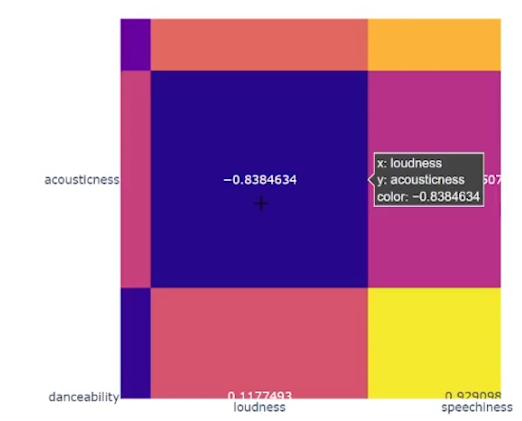

Obs: Nós temos diversos quadrados azuis. Gostaria de destacar o ponto y = acousticness, y = loudness. O valor dessa correlação é de -0,8, logo, se trata de um valor inverso, negativo. Significa que essas características são relacionadas, mas de maneira contrária: quanto mais acústica uma música é, menos barulhenta.

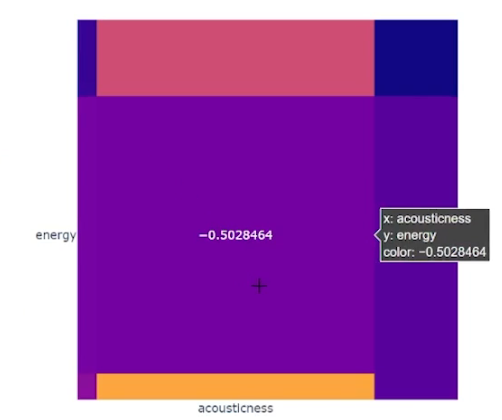

Outra análise que podemos fazer é do ponto x = acousticness, y = energy. Essa correlação tem valor -0,5. Quer dizer que elas são relacionadas e há uma tendência: quanto mais acústica uma música é, menos energética.

3.0 Clusterização por gênero musical

3.1 StandardScaler

Vamos analisar um novo Dataframe com a mesma estrutura do anterior, onde observamos como as características musicais mudaram, em média, ao longo dos anos. Desta vez, vamos calcular essas variações para cada gênero musical individualmente.

In [22]:
url_dados_generos = 'https://github.com/IgorNascAlves/dados/blob/main/dados_musicas_genero.csv?raw=true'

sessao_spark.sparkContext.addFile(url_dados_generos)
path_dados_file = "file://" + SparkFiles.get("dados_musicas_genero.csv")

dados_generos = sessao_spark.read.csv(path_dados_file, header=True, inferSchema= True)

Visualizando os dados de dados de gênero:

In [23]:
dados_generos.show()

+----+--------------------+-------------------+-------------------+------------------+-------------------+--------------------+-------------------+-------------------+--------------------+------------------+-------------------+------------------+---+
|mode|              genres|       acousticness|       danceability|       duration_ms|             energy|    instrumentalness|           liveness|           loudness|         speechiness|             tempo|            valence|        popularity|key|
+----+--------------------+-------------------+-------------------+------------------+-------------------+--------------------+-------------------+-------------------+--------------------+------------------+-------------------+------------------+---+
|   1|21st century clas...| 0.9793333333333332|0.16288333333333335|160297.66666666663|0.07131666666666665|          0.60683367|             0.3616|-31.514333333333337| 0.04056666666666667|           75.3365|0.10378333333333334| 27.83333333333333| 

Verificando a quantidade de linhas:

In [24]:
dados_generos.count()

2973

Verificando a quantidade de gêneros:

In [25]:
dados_generos.select('genres').distinct().count()

2973

Obs: Foi verificado que temos um gênero musical por linha.

Verificando a quantidade de caracteristicas musicais:

In [26]:
len(dados_generos.columns)

14

Ao trabalharmos com o Spark, um ponto importante é fazer a transformação da nossa base de dados. Temos diversas colunas representando os dados e o Spark, para aplicar determinadas técnicas, funciona vetorizando as colunas. Então, ao invés de várias colunas, queremos uma com um grande vetor que represente os dados:

In [27]:
from pyspark.ml.feature import VectorAssembler

In [28]:
dados_generos.columns

['mode',
 'genres',
 'acousticness',
 'danceability',
 'duration_ms',
 'energy',
 'instrumentalness',
 'liveness',
 'loudness',
 'speechiness',
 'tempo',
 'valence',
 'popularity',
 'key']

In [29]:
X = dados_generos.columns
X.remove('genres')
X

['mode',
 'acousticness',
 'danceability',
 'duration_ms',
 'energy',
 'instrumentalness',
 'liveness',
 'loudness',
 'speechiness',
 'tempo',
 'valence',
 'popularity',
 'key']

Criando o vetorizador:

In [30]:
dados_generos_vector = VectorAssembler(inputCols=X, outputCol='features').transform(dados_generos).select(['features', 'genres'])

Visualizando os dados:

In [31]:
dados_generos_vector.show()

+--------------------+--------------------+
|            features|              genres|
+--------------------+--------------------+
|[1.0,0.9793333333...|21st century clas...|
|[1.0,0.49478,0.29...|               432hz|
|[1.0,0.762,0.7120...|               8-bit|
|[1.0,0.6514170195...|                  []|
|[1.0,0.6765573049...|          a cappella|
|[1.0,0.45921,0.51...|            abstract|
|[1.0,0.3421466666...|      abstract beats|
|[1.0,0.2438540633...|    abstract hip hop|
|[0.0,0.3229999999...|           accordeon|
|[1.0,0.446125,0.6...|           accordion|
|[0.0,0.0679505384...|          acid house|
|[1.0,0.2569145079...|           acid rock|
|[1.0,0.00683,0.66...|         acid trance|
|[1.0,0.9170191062...|          acousmatic|
|[1.0,0.7617235394...|      acoustic blues|
|[1.0,0.4902350260...|        acoustic pop|
|[1.0,0.4049000220...|       acoustic punk|
|[1.0,0.6132007936...|       acoustic rock|
|[0.0,0.229,0.412,...|         action rock|
|[1.0,0.4328571428...|          

Queremos criar componentes que representarão as variações dos dados com a técnica PCA e será necessário aplicar outra técnica chamada Standardscaler, que vai fazer uma conta, permitindo que todas as nossas colunas estejam na mesma escala:

In [32]:
from pyspark.ml.feature import StandardScaler

In [33]:
scaler = StandardScaler(inputCol='features', outputCol='scaled_features')
scaler_model = scaler.fit(dados_generos_vector)
dados_generos_scaler = scaler_model.transform(dados_generos_vector)

Visualisando o resultado:

In [34]:
dados_generos_scaler.show()

+--------------------+--------------------+--------------------+
|            features|              genres|     scaled_features|
+--------------------+--------------------+--------------------+
|[1.0,0.9793333333...|21st century clas...|[2.68174831000279...|
|[1.0,0.49478,0.29...|               432hz|[2.68174831000279...|
|[1.0,0.762,0.7120...|               8-bit|[2.68174831000279...|
|[1.0,0.6514170195...|                  []|[2.68174831000279...|
|[1.0,0.6765573049...|          a cappella|[2.68174831000279...|
|[1.0,0.45921,0.51...|            abstract|[2.68174831000279...|
|[1.0,0.3421466666...|      abstract beats|[2.68174831000279...|
|[1.0,0.2438540633...|    abstract hip hop|[2.68174831000279...|
|[0.0,0.3229999999...|           accordeon|[0.0,1.0101313736...|
|[1.0,0.446125,0.6...|           accordion|[2.68174831000279...|
|[0.0,0.0679505384...|          acid house|[0.0,0.2125045534...|
|[1.0,0.2569145079...|           acid rock|[2.68174831000279...|
|[1.0,0.00683,0.66...|   

3.2 PCA - Principal Component Analysis

Já preparamos os nossos dados: vetorizamos, escalamos e, agora, estamos prontos para usarmos o PCA. Relembrando que a ideia do PCA é reunir as diversas features das 14 colunas e reduzi-las em apenas duas, permitindo, desta maneira, a construção de análises gráficas e um estudo mais apurado das informações.

In [35]:
from pyspark.ml.feature import PCA

In [36]:
pca = PCA(k=2, inputCol='scaled_features', outputCol='pca_features')
model_pca = pca.fit(dados_generos_scaler)
dados_generos_pca = model_pca.transform(dados_generos_scaler)

Visualizando os dados:

In [37]:
dados_generos_pca.select('pca_features').show(truncate=False)

+-----------------------------------------+
|pca_features                             |
+-----------------------------------------+
|[2.5070953668885667,0.43816913737697943] |
|[-0.5969679056633488,4.981612052751348]  |
|[-4.158460276223561,-0.8366525081079943] |
|[-2.387344878512217,-0.4877989015663405] |
|[-2.6501218371679083,-0.5756819768820474]|
|[-1.496509120336763,1.8644183183717797]  |
|[-3.923520772157324,0.2851835002352836]  |
|[-4.611011109831114,-0.6783790472312378] |
|[-2.837690063084229,-0.5712993716580518] |
|[-2.706690139892783,-1.25937880797083]   |
|[-4.6983313839242875,1.2765569680619446] |
|[-3.375987496679868,0.7560741064307471]  |
|[-5.608998877066021,1.0427311644393213]  |
|[0.2954946352117687,-0.2763864586236301] |
|[-2.5725591062870428,-1.3169815431109795]|
|[-3.4008228020493454,0.5073029625781897] |
|[-4.366720316263419,-0.3364827059771091] |
|[-2.7254698167724003,0.5058604987046365] |
|[-4.958112358381605,1.2627579957290729]  |
|[-3.6934951846422712,1.38227620

Criando um pipeline que guardará toda essa estratégia de transformação de dados em um objeto só:

In [38]:
from pyspark.ml import Pipeline

In [39]:
pca_pipeline = Pipeline(stages=[VectorAssembler(inputCols=X, outputCol='features'),
                                StandardScaler(inputCol='features', outputCol='scaled_features'),
                                PCA(k=2, inputCol='scaled_features', outputCol='pca_features')])

Ajustando o Pipeline:

In [40]:
pca_pipeline_model = pca_pipeline.fit(dados_generos)

Fazendo a transformação dos nossos dados:

In [41]:
dados_generos_pca = pca_pipeline_model.transform(dados_generos)

Visualizando os dados:

In [42]:
dados_generos_pca.show()

+----+--------------------+-------------------+-------------------+------------------+-------------------+--------------------+-------------------+-------------------+--------------------+------------------+-------------------+------------------+---+--------------------+--------------------+--------------------+
|mode|              genres|       acousticness|       danceability|       duration_ms|             energy|    instrumentalness|           liveness|           loudness|         speechiness|             tempo|            valence|        popularity|key|            features|     scaled_features|        pca_features|
+----+--------------------+-------------------+-------------------+------------------+-------------------+--------------------+-------------------+-------------------+--------------------+------------------+-------------------+------------------+---+--------------------+--------------------+--------------------+
|   1|21st century clas...| 0.9793333333333332|0.162883333

Visualizando a última coluna:

In [43]:
dados_generos_pca.select('pca_features').show(truncate=False)

+-----------------------------------------+
|pca_features                             |
+-----------------------------------------+
|[2.5070953668885667,0.43816913737697943] |
|[-0.5969679056633488,4.981612052751348]  |
|[-4.158460276223561,-0.8366525081079943] |
|[-2.387344878512217,-0.4877989015663405] |
|[-2.6501218371679083,-0.5756819768820474]|
|[-1.496509120336763,1.8644183183717797]  |
|[-3.923520772157324,0.2851835002352836]  |
|[-4.611011109831114,-0.6783790472312378] |
|[-2.837690063084229,-0.5712993716580518] |
|[-2.706690139892783,-1.25937880797083]   |
|[-4.6983313839242875,1.2765569680619446] |
|[-3.375987496679868,0.7560741064307471]  |
|[-5.608998877066021,1.0427311644393213]  |
|[0.2954946352117687,-0.2763864586236301] |
|[-2.5725591062870428,-1.3169815431109795]|
|[-3.4008228020493454,0.5073029625781897] |
|[-4.366720316263419,-0.3364827059771091] |
|[-2.7254698167724003,0.5058604987046365] |
|[-4.958112358381605,1.2627579957290729]  |
|[-3.6934951846422712,1.38227620

Obs: Fizemos um resumo das nossas features, isto é, dos nossos dados de gêneros musicais, em apenas duas componentes e estamos prontos para agruparmos esses diversos gêneros musicais para descobrirmos se realmente são próximos uns dos outros, em outras palavras, se apenas com as características musicais é possível fazer esses agrupamentos.

3.3 K-Means

Fazendo o agrupamento:

In [44]:
from pyspark.ml.clustering import KMeans

Definindo o Seed:

In [45]:
SEED = 1224

Definindo uma váriavel:

In [46]:
kmeans = KMeans(featuresCol='pca_features', predictionCol='cluster_pca').setK(5).setSeed(SEED)

Ajustando o algoritmo:

In [47]:
model_kmeans = kmeans.fit(dados_generos_pca)

Salvando as informações:

In [48]:
predictions_kmeans = model_kmeans.transform(dados_generos_pca)

Visualizano o dataframe:

In [49]:
predictions_kmeans.show()

+----+--------------------+-------------------+-------------------+------------------+-------------------+--------------------+-------------------+-------------------+--------------------+------------------+-------------------+------------------+---+--------------------+--------------------+--------------------+-----------+
|mode|              genres|       acousticness|       danceability|       duration_ms|             energy|    instrumentalness|           liveness|           loudness|         speechiness|             tempo|            valence|        popularity|key|            features|     scaled_features|        pca_features|cluster_pca|
+----+--------------------+-------------------+-------------------+------------------+-------------------+--------------------+-------------------+-------------------+--------------------+------------------+-------------------+------------------+---+--------------------+--------------------+--------------------+-----------+
|   1|21st century cla

Selecionando as inforamções necessárias:

In [50]:
predictions_kmeans.select('pca_features', 'cluster_pca').show(truncate=False)

+-----------------------------------------+-----------+
|pca_features                             |cluster_pca|
+-----------------------------------------+-----------+
|[2.5070953668885667,0.43816913737697943] |2          |
|[-0.5969679056633488,4.981612052751348]  |2          |
|[-4.158460276223561,-0.8366525081079943] |4          |
|[-2.387344878512217,-0.4877989015663405] |0          |
|[-2.6501218371679083,-0.5756819768820474]|0          |
|[-1.496509120336763,1.8644183183717797]  |2          |
|[-3.923520772157324,0.2851835002352836]  |4          |
|[-4.611011109831114,-0.6783790472312378] |1          |
|[-2.837690063084229,-0.5712993716580518] |4          |
|[-2.706690139892783,-1.25937880797083]   |0          |
|[-4.6983313839242875,1.2765569680619446] |3          |
|[-3.375987496679868,0.7560741064307471]  |4          |
|[-5.608998877066021,1.0427311644393213]  |1          |
|[0.2954946352117687,-0.2763864586236301] |2          |
|[-2.5725591062870428,-1.3169815431109795]|0    

3.4 Plotando o clustering

Transformando o vetor em colunas:

In [51]:
from pyspark.ml.functions import vector_to_array

In [52]:
pca_features_xy = predictions_kmeans.withColumn('x', vector_to_array('pca_features')[0])\
                  .withColumn('y', vector_to_array('pca_features')[1])\
                  .select(['x', 'y', 'cluster_pca', 'genres'])

Visualizando os dados:

0.4 Clusterização por música

4.1 Redução da dimensionalidade


In [53]:
pca_features_xy.show()

+-------------------+-------------------+-----------+--------------------+
|                  x|                  y|cluster_pca|              genres|
+-------------------+-------------------+-----------+--------------------+
| 2.5070953668885667|0.43816913737697943|          2|21st century clas...|
|-0.5969679056633488|  4.981612052751348|          2|               432hz|
| -4.158460276223561|-0.8366525081079943|          4|               8-bit|
| -2.387344878512217|-0.4877989015663405|          0|                  []|
|-2.6501218371679083|-0.5756819768820474|          0|          a cappella|
| -1.496509120336763| 1.8644183183717797|          2|            abstract|
| -3.923520772157324| 0.2851835002352836|          4|      abstract beats|
| -4.611011109831114|-0.6783790472312378|          1|    abstract hip hop|
| -2.837690063084229|-0.5712993716580518|          4|           accordeon|
| -2.706690139892783|  -1.25937880797083|          0|           accordion|
|-4.6983313839242875| 1.2

Gráfico:

In [54]:
fig = px.scatter(pca_features_xy.toPandas(), x='x', y='y', color='cluster_pca', hover_data=['x','y', 'genres'])
fig.show()

Analisando o nosso cluster, percebemos que todas as nossas bolinhas, isto é, todos os pontos que são nossas músicas/gêneros musicais, estão muito próximos uns dos outros. A divisão entre os clusters está muito próxima. Alguns estão grudados, por exemplo, o cluster laranja está bem próximo do roxo e do amarelo. A partir disso, podemos concluir que não tivemos um bom resultado.

Isso pode estar relacionado com a quantidade de clusters que selecionamos, talvez precisássemos de menos clusters para representarmos esses pontos, mas isso é um tanto intuitivo, já que tínhamos dois mil e duzentos gêneros musicais, a tendência é que precisássemos de mais clusters.

O fato de termos um agrupamento pouco satisfatório pode estar ligado a outro fator: a quantidade de componentes que selecionamos no PCA. Embora dois fosse o ideal para fazermos o plot e visualizarmos o resultado, talvez não seja o ideal para representarmos as 13 componentes originais. Nesta passagem de 13 para 2, talvez tenhamos perdido muitas informações.

Resgatando informação do PCA:

In [55]:
pca_pipeline_model.stages[2]

PCAModel: uid=PCA_1836daab8837, k=2

Descobrindo quanto as nossas componentes estão explicando das nossas features:

In [56]:
pca_pipeline_model.stages[2].explainedVariance

DenseVector([0.2975, 0.1212])

Obs: Esses valores estão nos contando que a nossa primeira componente, o x, tem uma taxa de explicação de três variáveis. Das 14 que tínhamos, ele está explicando apenas 3. A nossa segunda componente está explicando apenas uma variável.

Então, ao total, temos quatro features sendo explicadas por essas nossas duas componentes, o que não é o suficiente, estamos perdendo muitas informações. Isso está ligado ao nosso resultado pouco satisfatório na clusterização dos dados.

04. Clusterização por música

4.1 Redução de dimensionalidade com PCA

Removovendo as colunas que não possuimos interesse:


In [58]:
X = dados.columns
X.remove('artists')
X.remove('id')
X.remove('name')
X.remove('artists_song')
X

['valence',
 'year',
 'acousticness',
 'danceability',
 'duration_ms',
 'energy',
 'explicit',
 'instrumentalness',
 'key',
 'liveness',
 'loudness',
 'mode',
 'popularity',
 'speechiness',
 'tempo']

Obs: Assim foi definido as features importantes.

Transformando as colunas em vetores:



In [59]:
dados_encoded_vector = VectorAssembler(inputCols=X, outputCol='features').transform(dados)

Visualizando a transformação, selecionando apenas a coluna de interesse onde temos todas as features reduzidas em um vetor:

In [62]:
dados_encoded_vector.select('features').show(truncate=False, n=5)

+-------------------------------------------------------------------------------------------------------------------------+
|features                                                                                                                 |
+-------------------------------------------------------------------------------------------------------------------------+
|[0.285,2000.0,0.00239,0.429,266773.0,0.6609999999999999,0.0,1.21E-4,11.0,0.234,-7.227,1.0,84.0,0.0281,173.372]           |
|[0.613,2000.0,0.143,0.843,270507.0,0.8059999999999999,1.0,0.0,4.0,0.0771,-5.9460000000000015,0.0,80.0,0.269,94.948]      |
|[0.4,2000.0,0.00958,0.556,216880.0,0.8640000000000001,0.0,0.0,3.0,0.209,-5.87,0.0,84.0,0.0584,105.143]                   |
|[0.5429999999999999,2000.0,0.00664,0.545,233933.0,0.865,0.0,1.1E-5,11.0,0.168,-5.7079999999999975,0.0,78.0,0.0286,99.009]|
|[0.76,2000.0,0.0302,0.949,284200.0,0.6609999999999999,1.0,0.0,5.0,0.0454,-4.244,0.0,80.0,0.0572,104.504]                 |
+-------

Ajustando a escala dos nossos dados para obtermos um bom resultado no PCA:

In [64]:
scaler = StandardScaler(inputCol='features', outputCol='features_scaled')
model_scaler = scaler.fit(dados_encoded_vector)
dados_musicas_scaler = model_scaler.transform(dados_encoded_vector)

Visualizando os dados escaldos:

In [65]:
dados_musicas_scaler.select('features_scaled').show(truncate=False, n=5)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|features_scaled                                                                                                                                                                                                                                                               |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[1.156596679221045,329.8170613984441,0.008403188822334736,2.5040545743834373,3.7858811737298526,2.980511298201045,0.0,6.070790766862789E-4,3.0696424994844875,1.4832857988766257,-1.

Definindo o número de componentes, onde nosso número de componentes, "k", será igual ao comprimento de x, que é a quantidade de features que temos.:

In [67]:
k = len(X)
k

15

Ajustando o PCA com o número de compenentes (15) identificados:

In [68]:
pca = PCA(k=k, inputCol='features_scaled', outputCol='pca_features')
model_pca = pca.fit(dados_musicas_scaler)
dados_musicais_pca = model_pca.transform(dados_musicas_scaler)


Entendendo o quanto nossas componentes estão explicando:

In [71]:
sum(model_pca.explainedVariance) * 100

99.99999999999999

Nossas componentes estão explicando 99,99. É uma excelente explicação, porém, não fizemos nenhuma redução de componentes. Estamos com o mesmo número de features e componentes. Então, precisamos fazer um cálculo para descobrir quantas componentes precisamos para chegarmos a certo nível de explained variance.

Nós não queremos somar toda a lista de variância, mas, sim, apenas algumas componentes, então abriremos colchetes e faremos a seleção da primeira componente, "0", até um componente determinada por "i", portanto [0:i+1]:


In [73]:
lista_valores = [sum(model_pca.explainedVariance[0:i+1]) for i in range(k)]
lista_valores

[0.21297354127107343,
 0.34597741622955064,
 0.43989805678254446,
 0.5267820578269102,
 0.6001038103117928,
 0.6665719513652388,
 0.7282174213581727,
 0.7845103843321022,
 0.8350002357002613,
 0.8812446547406768,
 0.9151737562703046,
 0.9435370133056037,
 0.9699018569070159,
 0.9900947792885578,
 0.9999999999999999]

Queremos encontrar uma somatória que chegue no número de componentes ideal. Para isso, precisaremos de uma nova ferramenta, o numpy:

In [74]:
import numpy as np

In [75]:
k = sum(np.array(lista_valores) <= 0.7)
k

6

In [76]:
pca = PCA(k=k, inputCol='features_scaled', outputCol='pca_features')
model_pca = pca.fit(dados_musicas_scaler)
dados_musicais_pca_final = model_pca.transform(dados_musicas_scaler)


Visualizando a coluna de interesse:


In [77]:
dados_musicais_pca_final.select('pca_features').show(truncate=False, n=5)

+----------------------------------------------------------------------------------------------------------------------+
|pca_features                                                                                                          |
+----------------------------------------------------------------------------------------------------------------------+
|[-34.71004464775704,-165.36848784906178,-11.163498729833321,-139.11374280854434,-14.152192300931375,6.254422223810391]|
|[-36.49885762774905,-167.85185045616555,-10.729023248907561,-135.904352656713,-13.388401890587229,3.972980727830861]  |
|[-35.460300916940554,-165.99633344577884,-11.361290348241592,-138.24276881247,-13.866654919305779,4.342675920458719]  |
|[-35.56301325520584,-165.59515096480607,-11.460226007031382,-137.52095740570041,-15.56854280392272,4.542073725584271] |
|[-36.54556974907567,-167.37512505802482,-11.881276527236555,-136.27798590243984,-14.05684799034454,3.583390145779156] |
+-------------------------------

Verificando se a taxa de explicação está próxima do que esperamos:

In [78]:
sum(model_pca.explainedVariance) * 100

66.65719513652388

Obs: Temos 66, então, estamos próximos dos 7 para apenas 6 componentes. Estamos prontos para seguirmos com o próximo passo que é consolidar todo o pipeline que criamos e utilizarmos o K-Means para criarmos nossos clusters.